# Calculate damages

Finally, we use the extracted flood and network data to perform an expected annual damages calculation

In [1]:
from glob import glob
import os

import geopandas as gpd
import pandas as pd
from pyproj import Geod
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import rasterio
from scipy.integrate import simpson, cumulative_trapezoid

from utils import aqueduct_rp
from rasterise import (
    check_raster_grid_consistent,
    split_linestrings,
    cell_indices_assigner,
    raster_lookup,
)

In [2]:
data_dir = "data"
country_iso = "bgd"

In [3]:
# flood hazard data to use, pulled from the autopkg API
epoch = 2050
scenario = "rcp4p5"
raster_paths = glob(f"data/{country_iso}/wri_aqueduct*/*{scenario}_wtsub_{epoch}*.tif")
raster_paths = sorted(raster_paths, key=aqueduct_rp, reverse=True)

(network_file,) = glob(f"data/{country_iso}/gri_osm*/*.gpkg")
network = gpd.read_file(network_file)

In [4]:
# filter network to linestrings only (edges)
lines = network[network.geometry.type == "LineString"]

# filter to roads
desired_layers = {"motorway", "primary", "secondary", "tertiary", "trunk"}
lines = lines[lines.asset_type.isin(desired_layers)]

# error if grids not consistent
check_raster_grid_consistent(raster_paths)

# split edges on raster grid
raster_path, *other_raster_paths = raster_paths
raster = rasterio.open(raster_path)
splits = split_linestrings(lines, raster)

# calculate split edge lengths
geod = Geod(ellps="WGS84")
meters_per_km = 1_000
splits["length_km"] = splits.geometry.apply(geod.geometry_length) / meters_per_km

# which cell is each split edge in?
assigner = cell_indices_assigner(raster)
raster_indices = splits.geometry.apply(assigner)

# join raster indices to geometries with shared index
splits_with_raster_indices = splits.join(raster_indices)

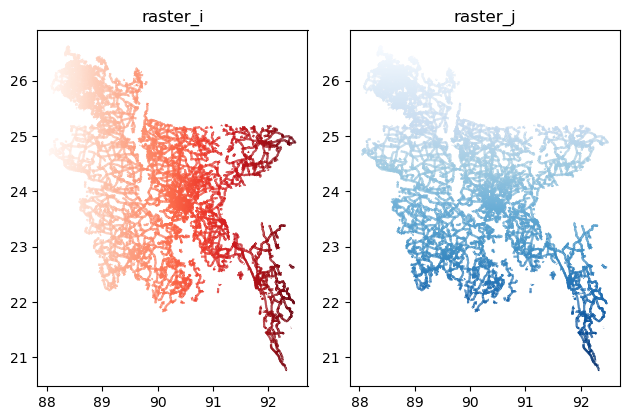

In [5]:
# map raster indices as visual check
f, (ax_i, ax_j) = plt.subplots(ncols=2)

ax_i = splits_with_raster_indices.plot(ax=ax_i, column="raster_i", cmap="Reds")
ax_i.set_title("raster_i")

splits_with_raster_indices.plot(ax=ax_j, column="raster_j", cmap="Blues")
ax_j.set_title("raster_j")
f.tight_layout()

In [6]:
for path in raster_paths:
    splits_with_raster_indices[f"rp-{aqueduct_rp(path)}"] = raster_lookup(
        splits_with_raster_indices, path
    )

hazard_intensities = splits_with_raster_indices
hazard_intensities.describe()

,original_index,length_km,raster_i,raster_j,rp-1000,rp-500,rp-250,rp-100,rp-50,rp-25,rp-10,rp-5,rp-2,rp-1
count,87451.000000,87451.000000,87451.000000,87451.000000,19527.000000,17747.000000,16011.000000,13796.000000,11662.000000,10066.000000,7764.000000,5729.000000,3568.000000,3237.000000
mean,19270.985649,0.412015,235.567998,289.800037,2.895500,2.688432,2.484948,2.203095,2.008075,1.810702,1.611740,1.504337,1.448874,1.453599
std,10600.618377,0.347525,130.507331,147.016411,1.891673,1.779430,1.670691,1.542288,1.467463,1.387197,1.277772,1.181062,1.099934,1.092027
min,1280.000000,0.000000,4.000000,0.000000,0.000208,0.001322,0.000654,0.000037,0.001917,0.000361,0.000075,0.000297,0.000238,0.000897
25%,10621.000000,0.097202,118.000000,182.000000,1.363033,1.251753,1.205906,0.994220,0.859733,0.722758,0.577750,0.502641,0.505615,0.486652
50%,19182.000000,0.314215,236.000000,295.000000,2.703255,2.466594,2.235559,1.909329,1.676258,1.465879,1.242367,1.227571,1.243547,1.256730
75%,28840.500000,0.713118,317.000000,396.000000,4.081157,3.756756,3.456736,3.079692,2.861825,2.625267,2.462285,2.353024,2.200343,2.184073
max,38371.000000,2.113199,536.000000,702.000000,9.815089,9.341475,8.867518,8.239826,7.763097,7.282821,6.635424,6.054329,5.597771,5.545167


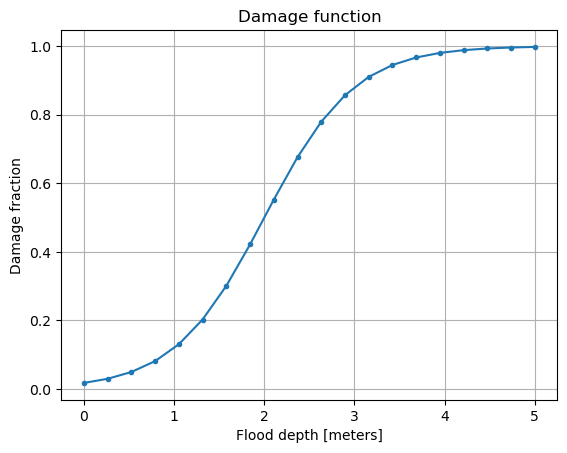

In [7]:
def logistic_min(
    x: float | np.ndarray, L: float, m: float, k: float, x_0: float
) -> float | np.ndarray:
    """
    Logistic function with a minimum value, m.

    Args:
        x: Input values
        L: Maximum output value
        m: Minimum output value
        k: Steepness parameter
        x_0: Location of sigmoid centre in x

    Returns:
        Output values
    """

    return m + (L - m) / (1 + np.exp(-k * (x - x_0)))


# define a damage function
damage_curve = lambda x: logistic_min(x, 1, 0, 2, 2)

# have a look at it
f, ax = plt.subplots()
x = np.linspace(0, 5, 20)
ax.plot(x, damage_curve(x), ".", ls="-")
ax.set_xlabel("Flood depth [meters]")
ax.set_ylabel("Damage fraction")
ax.set_title("Damage function")
ax.grid()

In [8]:
# calculate how badly each split edge is damaged by the flooding
damage_fractions = hazard_intensities.copy()
hazard_cols = [col for col in hazard_intensities.columns if col.startswith("rp-")]
damage_fractions[hazard_cols] = damage_fractions[hazard_cols].applymap(damage_curve)

In [9]:
# calculate the cost of damage
reconstruction_cost_currency_per_km = 1e5

damage_cost = damage_fractions.copy()
for col in hazard_cols:
    damage_cost[col] = (
        damage_cost[col] * damage_cost.length_km * reconstruction_cost_currency_per_km
    )

grouped_damage_cost = damage_cost[hazard_cols].groupby(damage_cost.original_index).sum()
probability_per_year = 1 / np.array(
    [int(col.replace("rp-", "")) for col in hazard_cols]
)

damage_probability_curve = grouped_damage_cost.copy()
damage_probability_curve.columns = probability_per_year

Text(0.5, 1.0, 'Damage-probability curve\nRCP4P5 2050')

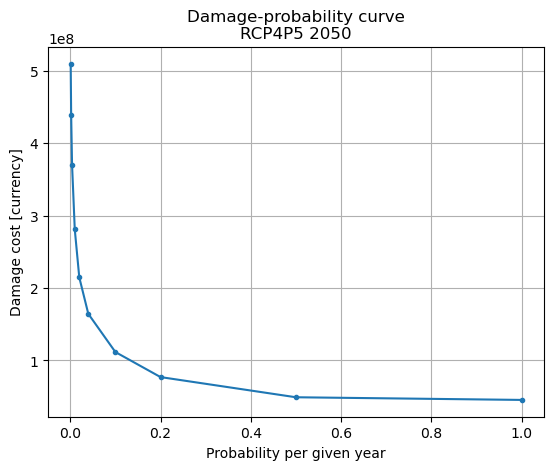

In [10]:
# plot the damage-probability curve
f, ax = plt.subplots()
damage_probability = damage_probability_curve.sum()
ax.plot(damage_probability.index, damage_probability.values, ".", ls="-")
ax.grid()
ax.set_xlabel("Probability per given year")
ax.set_ylabel("Damage cost [currency]")
ax.set_title(f"Damage-probability curve\n{scenario.upper()} {epoch}")

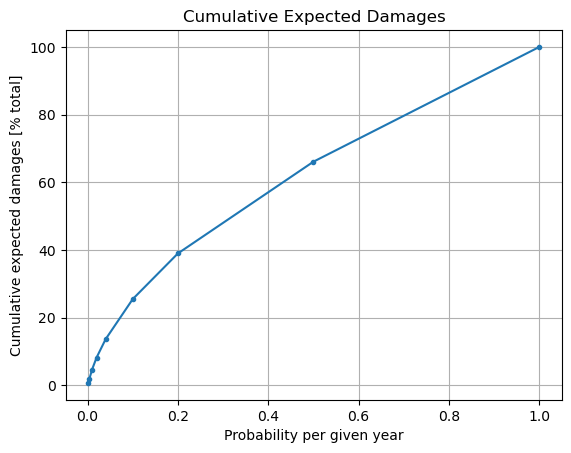

In [11]:
# check how the damage cost cumulatively grows as a function of probability
y = cumulative_trapezoid(grouped_damage_cost.sum(), probability_per_year)
f, ax = plt.subplots()
ax.plot(probability_per_year[1:], 100 * (y / y[-1]), ".", ls="-")
ax.set_xlabel("Probability per given year")
ax.set_ylabel("Cumulative expected damages [% total]")
ax.set_title("Cumulative Expected Damages")
# ax.set_xscale("log")
ax.grid()

# here, the tail risks aren't adding much to the expected annual damage figure

Text(0.5, 1.0, 'Expected Damages [currency per annum]\nTotal: 6.61E+07')

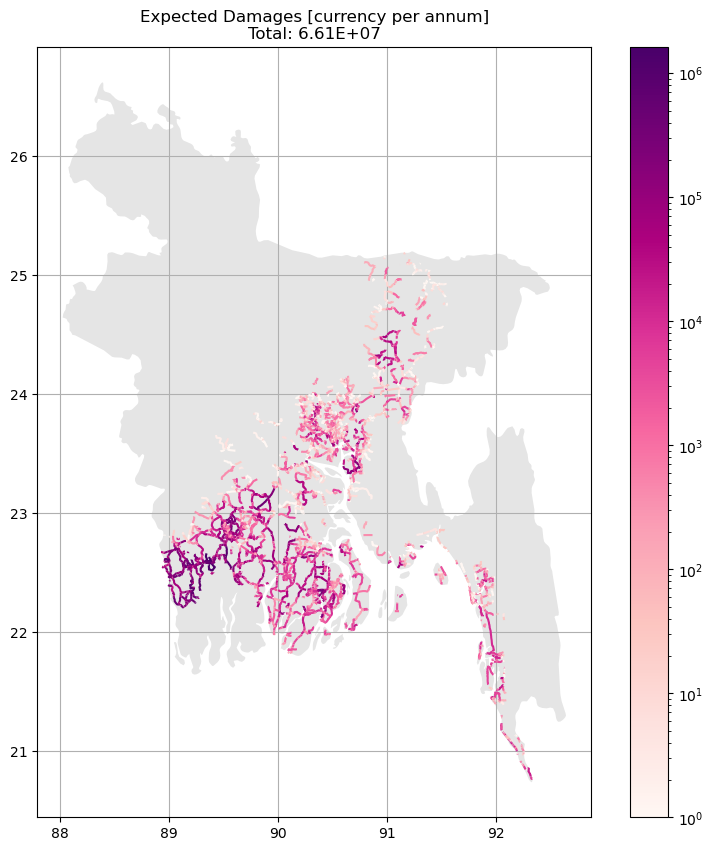

In [12]:
# calculate the expected annual damages for every edge
# that is, integrate the damage-probability curve, for every row
EAD = lines[["geometry"]].copy()
EAD["ead"] = simpson(grouped_damage_cost, x=probability_per_year, axis=1)

# map the expected annual damages
f, ax = plt.subplots(figsize=(10, 10))

border = gpd.read_file(os.path.join(data_dir, country_iso, "territory.gpkg"))
border.plot(ax=ax, alpha=0.1, color="black")

EAD.plot(
    ax=ax,
    column="ead",
    legend=True,
    cmap="RdPu",
    norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=EAD.ead.max()),
)
ax.grid()
ax.set_title(f"Expected Damages [currency per annum]\nTotal: {EAD.ead.sum():.2E}")